# Análisis de Rendimiento: Multiplicación de Matrices con OpenMP

Este notebook analiza el rendimiento de un programa de multiplicación de matrices parallelizado con OpenMP.

## Variables del experimento:
- **size**: Tamaño de la matriz (n×n)
- **np**: Número de cores/hilos utilizados
- **run**: Número de corrida del experimento (1-30, según teorema del límite central)
- **time_seconds**: Tiempo de ejecución en segundos

## 1. Carga de librerías y datos

In [1]:
# Cargar librerías necesarias
library(tidyverse)
library(ggplot2)
library(scales)

# Configuración de tema para gráficas
theme_set(theme_minimal(base_size = 12))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
# Cargar datos
datos <- read_csv("https://raw.githubusercontent.com/Samu-Kiss/UNI-26-10-Multiplicacion-de-Matrices-Distribuida/refs/heads/main/LaptopNode0/results.csv",
                  col_types = cols(
                    size = col_integer(),
                    np = col_integer(),
                    run = col_integer(),
                    time_seconds = col_double()
                  ))

# Visualizar estructura de los datos
glimpse(datos)

Rows: 300
Columns: 4
$ size         <int> 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 20…
$ np           <int> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, …
$ run          <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…
$ time_seconds <dbl> 0.015608, 0.015764, 0.013351, 0.006441, 0.013686, 0.01278…


## 2. Exploración inicial de datos

In [3]:
# Resumen estadístico básico
summary(datos)

      size            np          run        time_seconds      
 Min.   : 200   Min.   : 4   Min.   : 1.0   Min.   :4.421e-03  
 1st Qu.: 400   1st Qu.: 4   1st Qu.: 8.0   1st Qu.:5.782e-01  
 Median : 800   Median :12   Median :15.5   Median :5.024e+00  
 Mean   :1240   Mean   :12   Mean   :15.5   Mean   :3.935e+01  
 3rd Qu.:1600   3rd Qu.:20   3rd Qu.:23.0   3rd Qu.:2.681e+01  
 Max.   :3200   Max.   :20   Max.   :30.0   Max.   :2.200e+02  

In [4]:
# Configuraciones experimentales disponibles
cat("Tamaños de matriz:", unique(datos$size), "\n")
cat("Números de cores:", unique(datos$np), "\n")
cat("Corridas por configuración:", n_distinct(datos$run), "\n")

Tamaños de matriz: 200 400 800 1600 3200 
Números de cores: 4 20 
Corridas por configuración: 30 


## 3. Cálculo de métricas de rendimiento

Calcularemos las siguientes métricas:
- **Tiempo promedio**: Media del tiempo de ejecución por configuración
- **Desviación estándar**: Variabilidad de los tiempos
- **Intervalo de confianza (95%)**: Rango de confianza para el tiempo promedio
- **Speedup**: Aceleración respecto a la ejecución con np=1 (o np mínimo)
- **Eficiencia**: Speedup / número_de_cores × 100%

In [5]:
# Calcular estadísticas por configuración (size, np)
estadisticas <- datos %>%
  group_by(size, np) %>%
  summarise(
    n = n(),
    tiempo_promedio = mean(time_seconds),
    tiempo_mediana = median(time_seconds),
    desviacion_std = sd(time_seconds),
    error_std = sd(time_seconds) / sqrt(n()),
    ic_inferior = tiempo_promedio - qt(0.975, n()-1) * error_std,
    ic_superior = tiempo_promedio + qt(0.975, n()-1) * error_std,
    tiempo_min = min(time_seconds),
    tiempo_max = max(time_seconds),
    .groups = "drop"
  )

print(estadisticas)

# A tibble: 10 × 11
    size    np     n tiempo_promedio tiempo_mediana desviacion_std error_std
   <int> <int> <int>           <dbl>          <dbl>          <dbl>     <dbl>
 1   200     4    30          0.0150         0.0156        0.00453  0.000828
 2   200    20    30          0.892          0.800         0.336    0.0614  
 3   400     4    30          0.0861         0.0867        0.0104   0.00190 
 4   400    20    30          2.07           1.97          0.386    0.0705  
 5   800     4    30          0.599          0.584         0.0442   0.00807 
 6   800    20    30          7.42           7.32          0.781    0.143   
 7  1600     4    30         10.2           10.1           0.314    0.0573  
 8  1600    20    30         28.0           26.9           4.99     0.910   
 9  3200     4    30        210.           216.           11.6      2.11    
10  3200    20    30        134.           134.            7.02     1.28    
# ℹ 4 more variables: ic_inferior <dbl>, ic_superior <db

In [6]:
# Calcular Speedup y Eficiencia
# El speedup se calcula respecto al caso con menor número de cores para cada tamaño
metricas_rendimiento <- estadisticas %>%
  group_by(size) %>%
  mutate(
    tiempo_base = tiempo_promedio[np == min(np)],
    speedup = tiempo_base / tiempo_promedio,
    eficiencia = (speedup / np) * 100,
    speedup_ideal = np / min(np)
  ) %>%
  ungroup()

print(metricas_rendimiento)

# A tibble: 10 × 15
    size    np     n tiempo_promedio tiempo_mediana desviacion_std error_std
   <int> <int> <int>           <dbl>          <dbl>          <dbl>     <dbl>
 1   200     4    30          0.0150         0.0156        0.00453  0.000828
 2   200    20    30          0.892          0.800         0.336    0.0614  
 3   400     4    30          0.0861         0.0867        0.0104   0.00190 
 4   400    20    30          2.07           1.97          0.386    0.0705  
 5   800     4    30          0.599          0.584         0.0442   0.00807 
 6   800    20    30          7.42           7.32          0.781    0.143   
 7  1600     4    30         10.2           10.1           0.314    0.0573  
 8  1600    20    30         28.0           26.9           4.99     0.910   
 9  3200     4    30        210.           216.           11.6      2.11    
10  3200    20    30        134.           134.            7.02     1.28    
# ℹ 8 more variables: ic_inferior <dbl>, ic_superior <db

## 4. Visualización de resultados

### 4.1 Distribución de tiempos de ejecución
*Métrica evaluada: Variabilidad y distribución de los tiempos de ejecución*

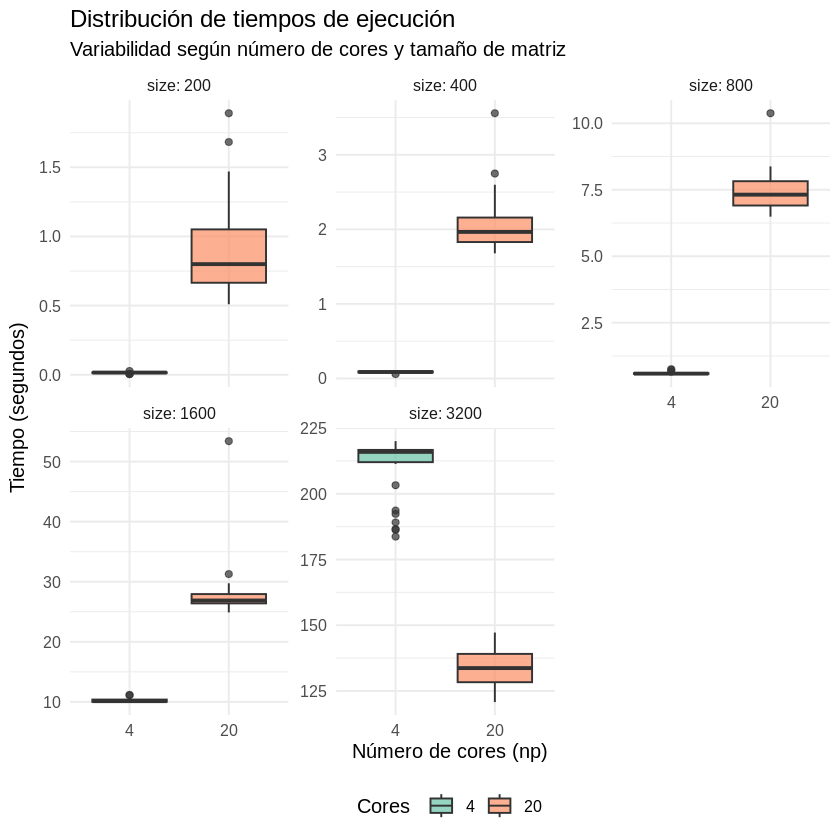

In [7]:
# Boxplot: Distribución de tiempos por configuración
ggplot(datos, aes(x = factor(np), y = time_seconds, fill = factor(np))) +
  geom_boxplot(alpha = 0.7) +
  facet_wrap(~size, scales = "free_y", labeller = label_both) +
  labs(
    title = "Distribución de tiempos de ejecución",
    subtitle = "Variabilidad según número de cores y tamaño de matriz",
    x = "Número de cores (np)",
    y = "Tiempo (segundos)",
    fill = "Cores"
  ) +
  scale_fill_brewer(palette = "Set2") +
  theme(legend.position = "bottom")

### 4.2 Tiempo promedio de ejecución con intervalos de confianza
*Métrica evaluada: Tiempo de ejecución promedio con IC 95%*

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


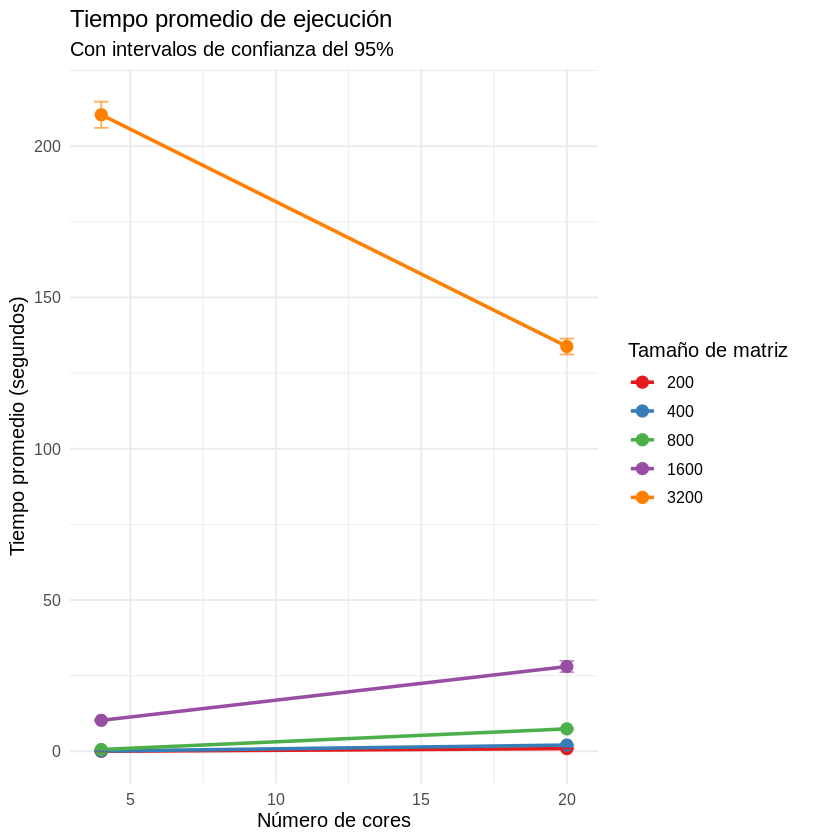

In [8]:
# Gráfica de líneas con intervalos de confianza
ggplot(metricas_rendimiento, aes(x = np, y = tiempo_promedio, color = factor(size))) +
  geom_line(size = 1) +
  geom_point(size = 3) +
  geom_errorbar(
    aes(ymin = ic_inferior, ymax = ic_superior),
    width = 0.5,
    alpha = 0.6
  ) +
  labs(
    title = "Tiempo promedio de ejecución",
    subtitle = "Con intervalos de confianza del 95%",
    x = "Número de cores",
    y = "Tiempo promedio (segundos)",
    color = "Tamaño de matriz"
  ) +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "right")

### 4.3 Speedup (Aceleración)
*Métrica evaluada: Factor de aceleración al aumentar el número de cores*

El speedup mide cuántas veces más rápido se ejecuta el programa con múltiples cores comparado con la configuración base.

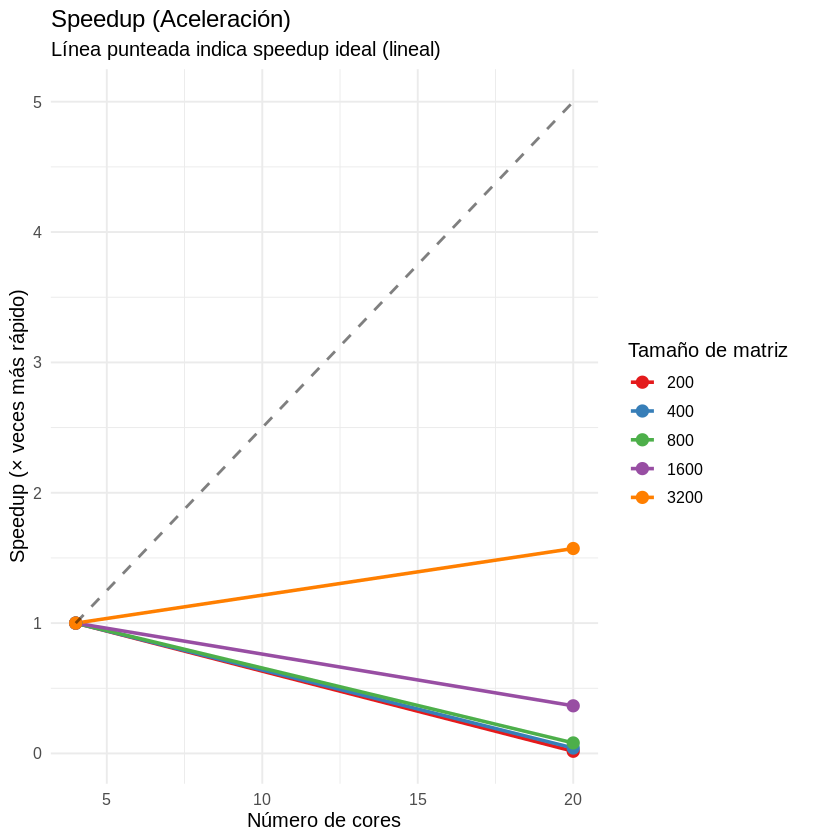

In [9]:
# Gráfica de Speedup vs número de cores
ggplot(metricas_rendimiento, aes(x = np, y = speedup, color = factor(size))) +
  geom_line(size = 1) +
  geom_point(size = 3) +
  geom_line(
    aes(y = speedup_ideal),
    linetype = "dashed",
    color = "black",
    size = 0.8,
    alpha = 0.5
  ) +
  labs(
    title = "Speedup (Aceleración)",
    subtitle = "Línea punteada indica speedup ideal (lineal)",
    x = "Número de cores",
    y = "Speedup (× veces más rápido)",
    color = "Tamaño de matriz"
  ) +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "right")

### 4.4 Eficiencia
*Métrica evaluada: Eficiencia de paralelización (%)*

La eficiencia mide qué tan bien se aprovechan los cores adicionales. Una eficiencia del 100% indica escalabilidad perfecta.

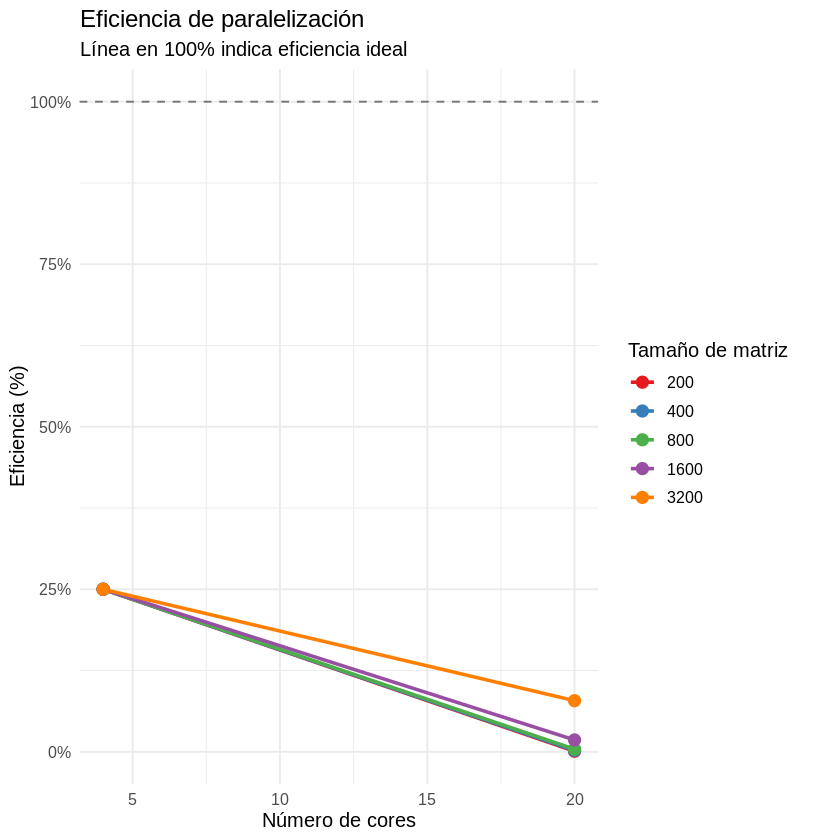

In [10]:
# Gráfica de Eficiencia
ggplot(metricas_rendimiento, aes(x = np, y = eficiencia, color = factor(size))) +
  geom_line(size = 1) +
  geom_point(size = 3) +
  geom_hline(yintercept = 100, linetype = "dashed", color = "black", alpha = 0.5) +
  labs(
    title = "Eficiencia de paralelización",
    subtitle = "Línea en 100% indica eficiencia ideal",
    x = "Número de cores",
    y = "Eficiencia (%)",
    color = "Tamaño de matriz"
  ) +
  scale_color_brewer(palette = "Set1") +
  scale_y_continuous(labels = percent_format(scale = 1)) +
  theme(legend.position = "right")

### 4.5 Coeficiente de variación
*Métrica evaluada: Estabilidad de las mediciones*

El coeficiente de variación (CV) mide la variabilidad relativa de los tiempos de ejecución.

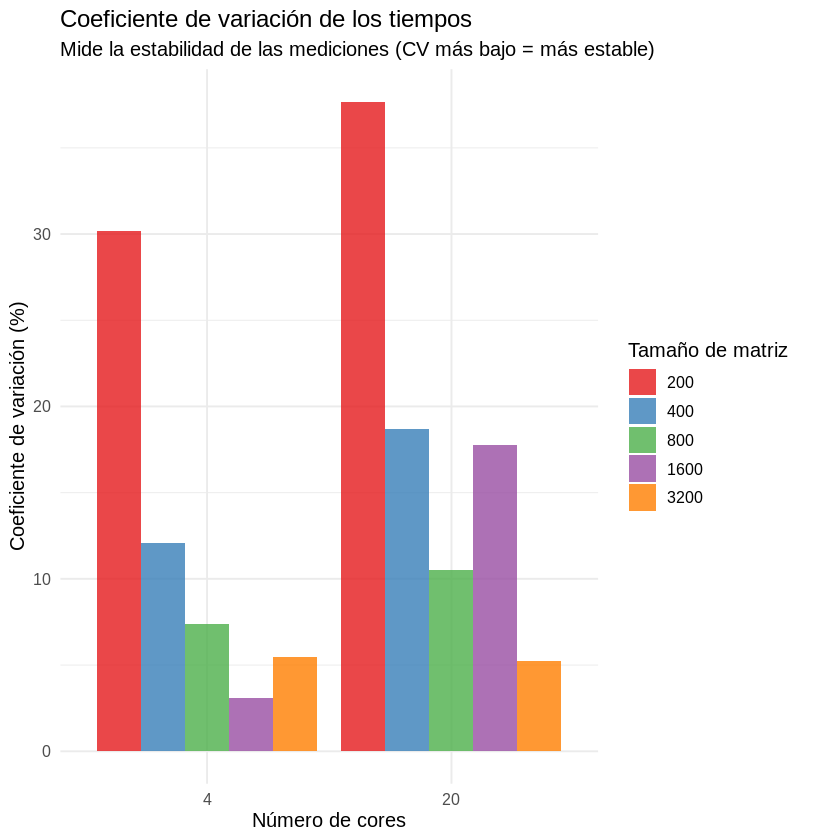

In [11]:
# Calcular coeficiente de variación
cv_datos <- estadisticas %>%
  mutate(cv = (desviacion_std / tiempo_promedio) * 100)

# Gráfica de coeficiente de variación
ggplot(cv_datos, aes(x = factor(np), y = cv, fill = factor(size))) +
  geom_col(position = "dodge", alpha = 0.8) +
  labs(
    title = "Coeficiente de variación de los tiempos",
    subtitle = "Mide la estabilidad de las mediciones (CV más bajo = más estable)",
    x = "Número de cores",
    y = "Coeficiente de variación (%)",
    fill = "Tamaño de matriz"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(legend.position = "right")

### 4.6 Heatmap de tiempos promedio
*Métrica evaluada: Comparación visual de rendimiento entre configuraciones*

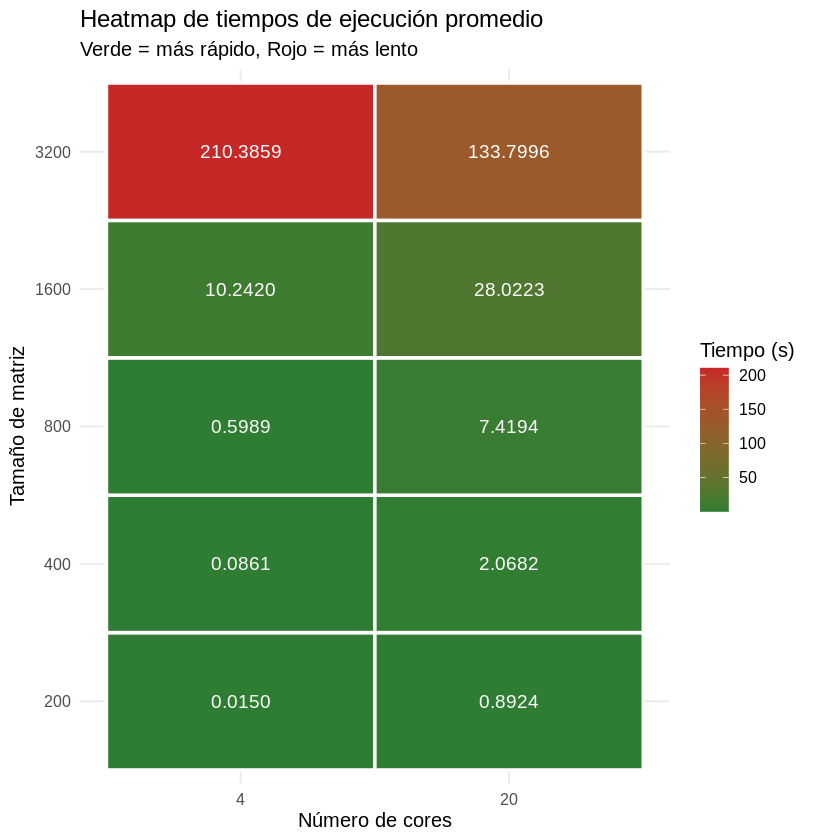

In [12]:
# Heatmap de tiempos promedio
ggplot(metricas_rendimiento, aes(x = factor(np), y = factor(size), fill = tiempo_promedio)) +
  geom_tile(color = "white", size = 1) +
  geom_text(aes(label = sprintf("%.4f", tiempo_promedio)), color = "white", size = 4) +
  scale_fill_gradient(low = "#2E7D32", high = "#C62828", name = "Tiempo (s)") +
  labs(
    title = "Heatmap de tiempos de ejecución promedio",
    subtitle = "Verde = más rápido, Rojo = más lento",
    x = "Número de cores",
    y = "Tamaño de matriz"
  ) +
  theme_minimal(base_size = 12)

### 4.7 Escalabilidad fuerte
*Métrica evaluada: Escalabilidad al aumentar recursos con problema fijo*

Análisis de cómo cambia el rendimiento al aumentar el número de cores para un tamaño de problema fijo.

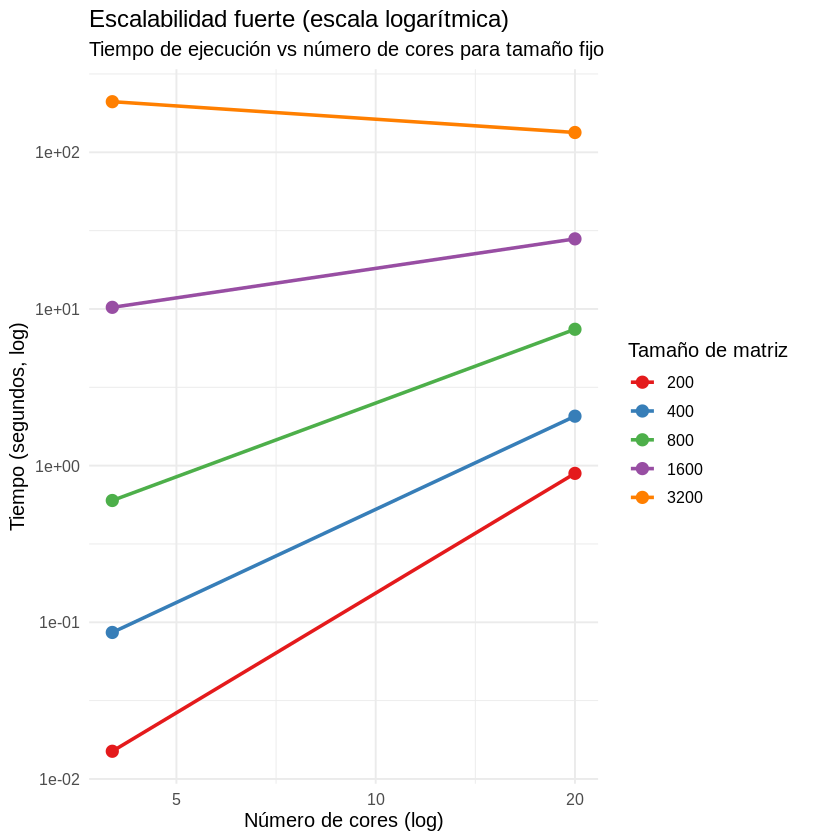

In [13]:
# Gráfica de escalabilidad fuerte (para cada tamaño de matriz)
ggplot(metricas_rendimiento, aes(x = np, y = tiempo_promedio)) +
  geom_line(aes(color = factor(size)), size = 1) +
  geom_point(aes(color = factor(size)), size = 3) +
  scale_y_log10() +
  scale_x_log10() +
  labs(
    title = "Escalabilidad fuerte (escala logarítmica)",
    subtitle = "Tiempo de ejecución vs número de cores para tamaño fijo",
    x = "Número de cores (log)",
    y = "Tiempo (segundos, log)",
    color = "Tamaño de matriz"
  ) +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "right")

## 5. Tabla resumen de resultados

In [14]:
# Tabla resumen con todas las métricas principales
tabla_resumen <- metricas_rendimiento %>%
  select(
    `Tamaño` = size,
    `Cores` = np,
    `Tiempo (s)` = tiempo_promedio,
    `Desv. Std` = desviacion_std,
    `Speedup` = speedup,
    `Eficiencia (%)` = eficiencia
  ) %>%
  mutate(
    `Tiempo (s)` = round(`Tiempo (s)`, 4),
    `Desv. Std` = round(`Desv. Std`, 4),
    `Speedup` = round(`Speedup`, 2),
    `Eficiencia (%)` = round(`Eficiencia (%)`, 2)
  )

print(tabla_resumen)

# A tibble: 10 × 6
   Tamaño Cores `Tiempo (s)` `Desv. Std` Speedup `Eficiencia (%)`
    <int> <int>        <dbl>       <dbl>   <dbl>            <dbl>
 1    200     4       0.015       0.0045    1               25   
 2    200    20       0.892       0.336     0.02             0.08
 3    400     4       0.0861      0.0104    1               25   
 4    400    20       2.07        0.386     0.04             0.21
 5    800     4       0.599       0.0442    1               25   
 6    800    20       7.42        0.781     0.08             0.4 
 7   1600     4      10.2         0.314     1               25   
 8   1600    20      28.0         4.99      0.37             1.83
 9   3200     4     210.         11.6       1               25   
10   3200    20     134.          7.02      1.57             7.86


## 6. Análisis adicionales

### 6.1 Violin Plot - Distribución detallada de tiempos
*Métrica evaluada: Forma de la distribución y densidad de los tiempos por configuración*

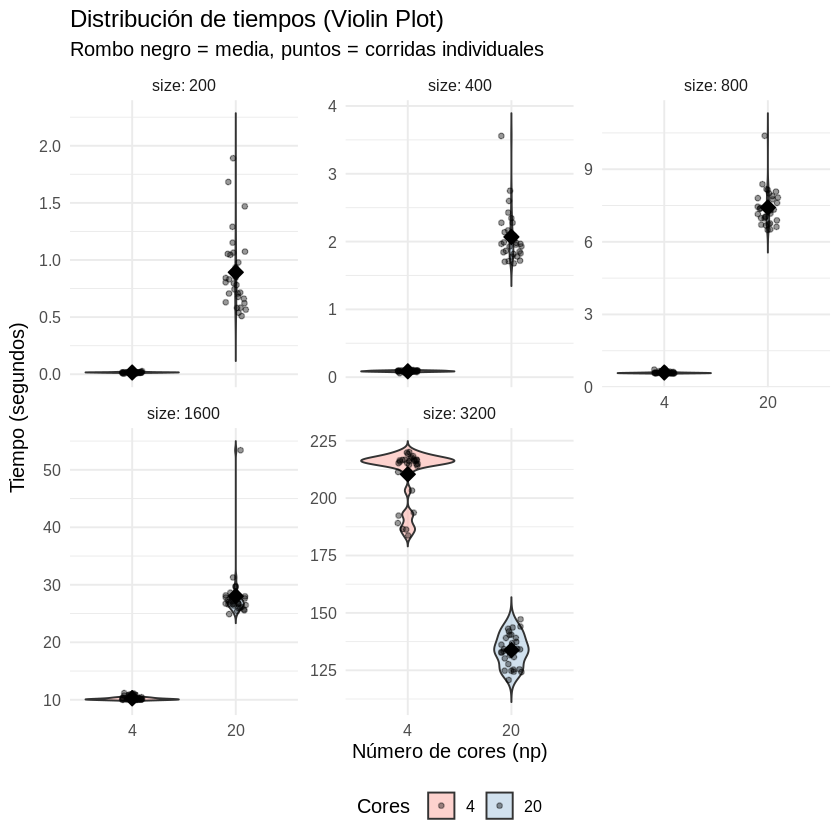

In [15]:
# Violin plot con puntos individuales
ggplot(datos, aes(x = factor(np), y = time_seconds, fill = factor(np))) +
  geom_violin(alpha = 0.6, trim = FALSE) +
  geom_jitter(width = 0.1, alpha = 0.4, size = 1.2) +
  stat_summary(fun = mean, geom = "point", shape = 23, size = 3,
               fill = "black", color = "black") +
  facet_wrap(~size, scales = "free_y", labeller = label_both) +
  labs(
    title = "Distribución de tiempos (Violin Plot)",
    subtitle = "Rombo negro = media, puntos = corridas individuales",
    x = "Número de cores (np)",
    y = "Tiempo (segundos)",
    fill = "Cores"
  ) +
  scale_fill_brewer(palette = "Pastel1") +
  theme(legend.position = "bottom")

### 6.2 Análisis de Overhead
*Métrica evaluada: Overhead de paralelización (tiempo adicional por usar más cores)*

El overhead se calcula como la diferencia entre el tiempo observado con 20 cores y el tiempo esperado si la paralelización fuera ideal.

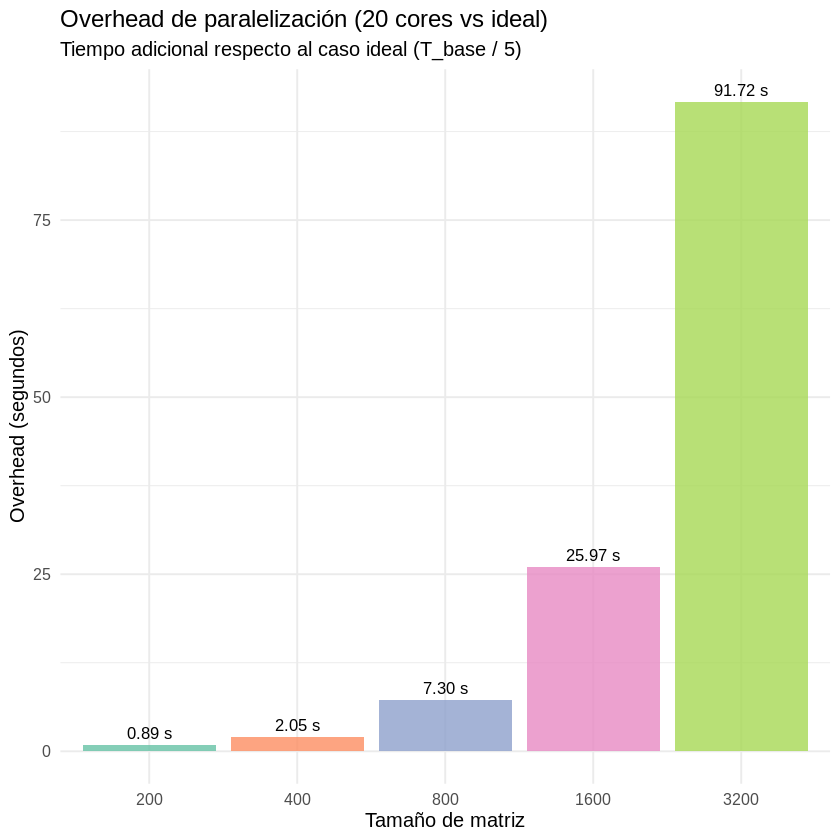

In [16]:
# Calcular overhead de paralelización
overhead <- metricas_rendimiento %>%
  mutate(
    tiempo_ideal = tiempo_base / (np / min(np)),
    overhead_absoluto = tiempo_promedio - tiempo_ideal,
    overhead_relativo = (overhead_absoluto / tiempo_ideal) * 100
  ) %>%
  filter(np == max(np))  # Solo para 20 cores

# Gráfica de overhead absoluto
ggplot(overhead, aes(x = factor(size), y = overhead_absoluto, fill = factor(size))) +
  geom_col(alpha = 0.8) +
  geom_text(aes(label = sprintf("%.2f s", overhead_absoluto)), vjust = -0.5, size = 3.5) +
  labs(
    title = "Overhead de paralelización (20 cores vs ideal)",
    subtitle = "Tiempo adicional respecto al caso ideal (T_base / 5)",
    x = "Tamaño de matriz",
    y = "Overhead (segundos)",
    fill = "Tamaño"
  ) +
  scale_fill_brewer(palette = "Set2") +
  theme(legend.position = "none")

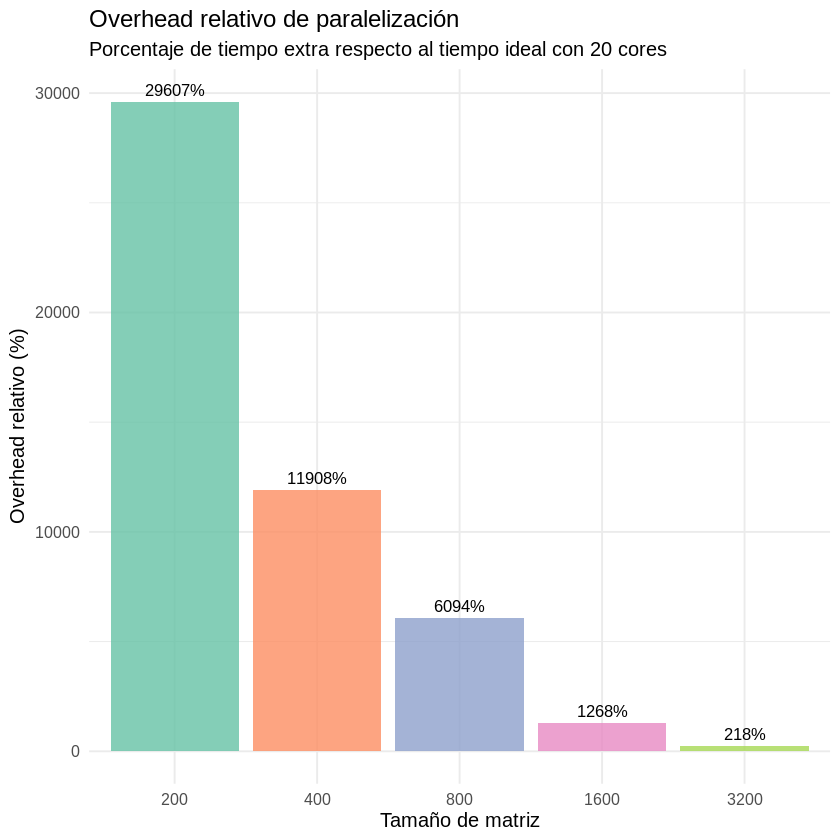

In [17]:
# Gráfica de overhead relativo (%)
ggplot(overhead, aes(x = factor(size), y = overhead_relativo, fill = factor(size))) +
  geom_col(alpha = 0.8) +
  geom_text(aes(label = sprintf("%.0f%%", overhead_relativo)), vjust = -0.5, size = 3.5) +
  labs(
    title = "Overhead relativo de paralelización",
    subtitle = "Porcentaje de tiempo extra respecto al tiempo ideal con 20 cores",
    x = "Tamaño de matriz",
    y = "Overhead relativo (%)"
  ) +
  scale_fill_brewer(palette = "Set2") +
  theme(legend.position = "none")

### 6.3 Comparación lado a lado por tamaño de matriz
*Métrica evaluada: Comparación directa entre 4 y 20 cores para cada tamaño*

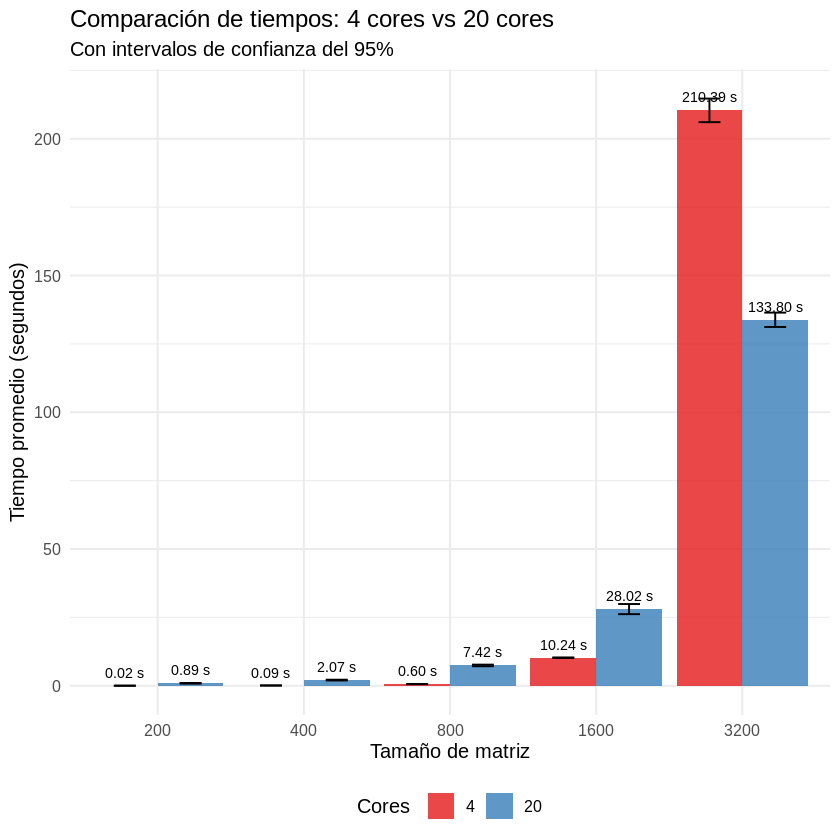

In [18]:
# Barras agrupadas de tiempo promedio por tamaño y cores
ggplot(metricas_rendimiento, aes(x = factor(size), y = tiempo_promedio, fill = factor(np))) +
  geom_col(position = "dodge", alpha = 0.8) +
  geom_errorbar(
    aes(ymin = ic_inferior, ymax = ic_superior),
    position = position_dodge(width = 0.9),
    width = 0.3
  ) +
  geom_text(
    aes(label = sprintf("%.2f s", tiempo_promedio)),
    position = position_dodge(width = 0.9),
    vjust = -0.8, size = 3
  ) +
  labs(
    title = "Comparación de tiempos: 4 cores vs 20 cores",
    subtitle = "Con intervalos de confianza del 95%",
    x = "Tamaño de matriz",
    y = "Tiempo promedio (segundos)",
    fill = "Cores"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(legend.position = "bottom")

### 6.4 Dispersión de corridas individuales
*Métrica evaluada: Comportamiento de cada corrida individual a lo largo de las 30 repeticiones*

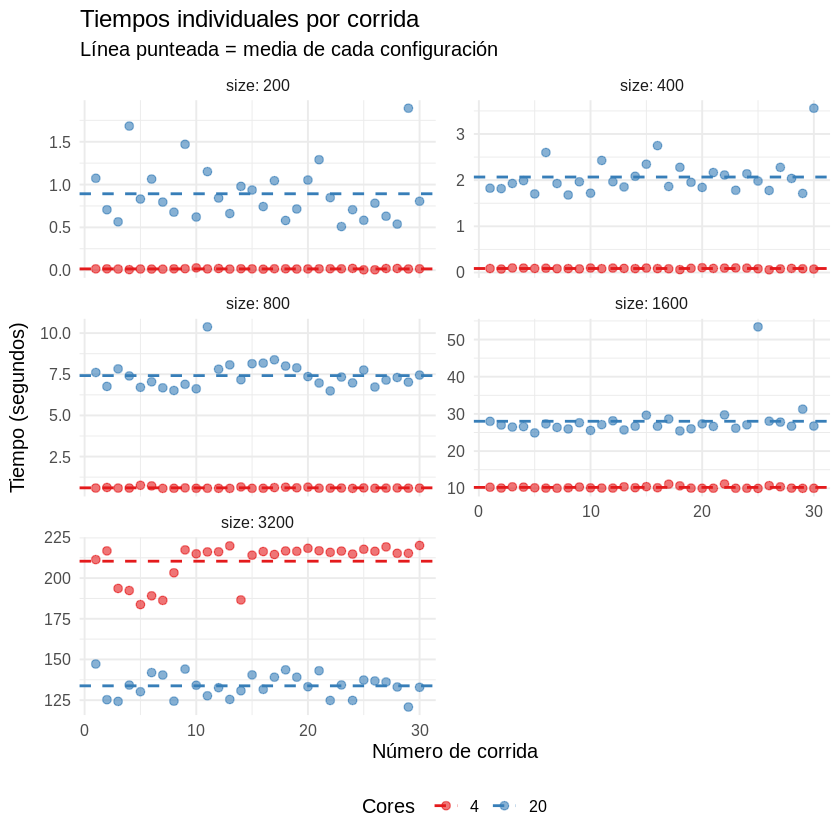

In [19]:
# Scatter plot de corridas individuales con línea de media
ggplot(datos, aes(x = run, y = time_seconds, color = factor(np))) +
  geom_point(alpha = 0.6, size = 2) +
  geom_hline(data = estadisticas, aes(yintercept = tiempo_promedio, color = factor(np)),
             linetype = "dashed", size = 0.8) +
  facet_wrap(~size, scales = "free_y", labeller = label_both, ncol = 2) +
  labs(
    title = "Tiempos individuales por corrida",
    subtitle = "Línea punteada = media de cada configuración",
    x = "Número de corrida",
    y = "Tiempo (segundos)",
    color = "Cores"
  ) +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "bottom")

### 6.5 Crecimiento del tiempo según tamaño de matriz
*Métrica evaluada: Complejidad computacional observada (crecimiento del tiempo vs tamaño)*

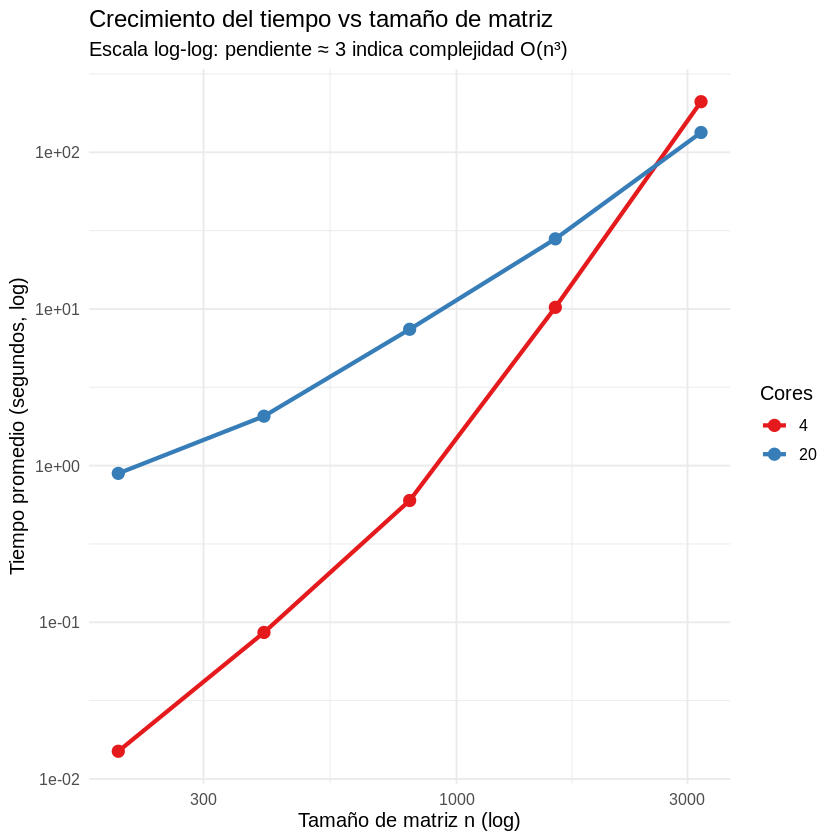

In [20]:
# Crecimiento del tiempo vs tamaño de matriz (log-log para ver complejidad)
ggplot(metricas_rendimiento, aes(x = size, y = tiempo_promedio, color = factor(np))) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  scale_x_log10() +
  scale_y_log10() +
  labs(
    title = "Crecimiento del tiempo vs tamaño de matriz",
    subtitle = "Escala log-log: pendiente ≈ 3 indica complejidad O(n³)",
    x = "Tamaño de matriz n (log)",
    y = "Tiempo promedio (segundos, log)",
    color = "Cores"
  ) +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "right")

### 6.6 Histograma de densidad por configuración
*Métrica evaluada: Distribución de frecuencias de los tiempos de ejecución*

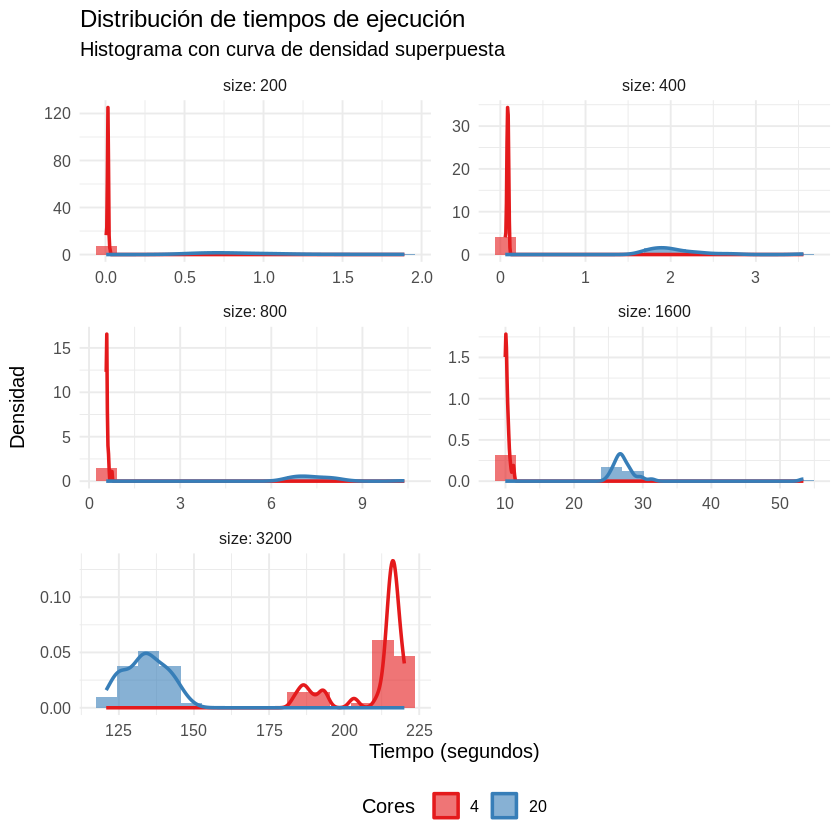

In [21]:
# Histograma con curva de densidad
ggplot(datos, aes(x = time_seconds, fill = factor(np))) +
  geom_histogram(aes(y = after_stat(density)), bins = 15, alpha = 0.6, position = "identity") +
  geom_density(aes(color = factor(np)), size = 1, alpha = 0) +
  facet_wrap(~size, scales = "free", labeller = label_both, ncol = 2) +
  labs(
    title = "Distribución de tiempos de ejecución",
    subtitle = "Histograma con curva de densidad superpuesta",
    x = "Tiempo (segundos)",
    y = "Densidad",
    fill = "Cores",
    color = "Cores"
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "bottom")

### 6.7 Razón de tiempos (20 cores / 4 cores)
*Métrica evaluada: Factor de desaceleración/aceleración al usar 20 cores en lugar de 4*

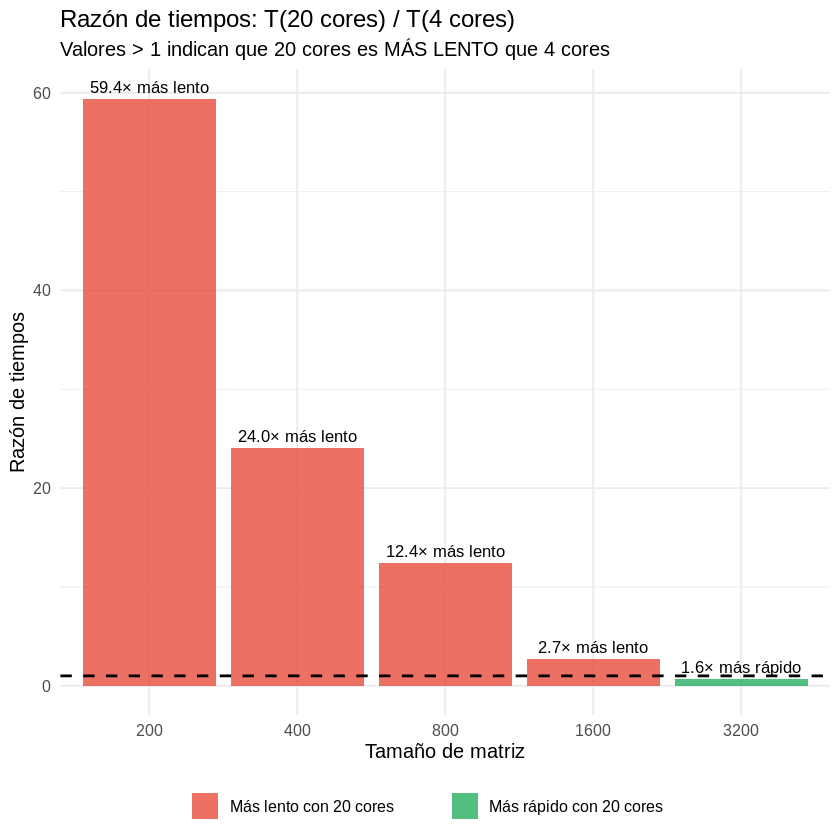

In [22]:
# Calcular razón de tiempos
razon_tiempos <- metricas_rendimiento %>%
  select(size, np, tiempo_promedio) %>%
  pivot_wider(names_from = np, values_from = tiempo_promedio, names_prefix = "np") %>%
  mutate(
    razon = np20 / np4,
    label_razon = ifelse(razon > 1,
                         sprintf("%.1f× más lento", razon),
                         sprintf("%.1f× más rápido", 1/razon)),
    color_razon = ifelse(razon > 1, "Más lento con 20 cores", "Más rápido con 20 cores")
  )

ggplot(razon_tiempos, aes(x = factor(size), y = razon, fill = color_razon)) +
  geom_col(alpha = 0.8) +
  geom_hline(yintercept = 1, linetype = "dashed", color = "black", size = 0.8) +
  geom_text(aes(label = label_razon), vjust = -0.5, size = 3.5) +
  labs(
    title = "Razón de tiempos: T(20 cores) / T(4 cores)",
    subtitle = "Valores > 1 indican que 20 cores es MÁS LENTO que 4 cores",
    x = "Tamaño de matriz",
    y = "Razón de tiempos",
    fill = ""
  ) +
  scale_fill_manual(values = c("Más lento con 20 cores" = "#E74C3C",
                                "Más rápido con 20 cores" = "#27AE60")) +
  theme(legend.position = "bottom")

## 7. Tabla resumen completa

In [23]:
# Tabla resumen completa con overhead
tabla_completa <- metricas_rendimiento %>%
  mutate(
    tiempo_ideal = tiempo_base / (np / min(np)),
    overhead_abs = tiempo_promedio - tiempo_ideal,
    overhead_pct = (overhead_abs / tiempo_ideal) * 100,
    cv = (desviacion_std / tiempo_promedio) * 100
  ) %>%
  select(
    `Tamaño` = size,
    `Cores` = np,
    `T. Promedio (s)` = tiempo_promedio,
    `Desv. Std (s)` = desviacion_std,
    `CV (%)` = cv,
    `IC inf` = ic_inferior,
    `IC sup` = ic_superior,
    `Speedup` = speedup,
    `Eficiencia (%)` = eficiencia,
    `Overhead (s)` = overhead_abs,
    `Overhead (%)` = overhead_pct
  ) %>%
  mutate(across(where(is.numeric), ~round(., 4)))

print(tabla_completa, width = Inf)

# A tibble: 10 × 11
   Tamaño Cores `T. Promedio (s)` `Desv. Std (s)` `CV (%)` `IC inf` `IC sup`
    <dbl> <dbl>             <dbl>           <dbl>    <dbl>    <dbl>    <dbl>
 1    200     4            0.015           0.0045    30.2    0.0133   0.0167
 2    200    20            0.892           0.336     37.7    0.767    1.02  
 3    400     4            0.0861          0.0104    12.1    0.0822   0.09  
 4    400    20            2.07            0.386     18.7    1.92     2.21  
 5    800     4            0.599           0.0442     7.38   0.582    0.615 
 6    800    20            7.42            0.781     10.5    7.13     7.71  
 7   1600     4           10.2             0.314      3.07  10.1     10.4   
 8   1600    20           28.0             4.99      17.8   26.2     29.9   
 9   3200     4          210.             11.6        5.49 206.     215.    
10   3200    20          134.              7.02       5.25 131.     136.    
   Speedup `Eficiencia (%)` `Overhead (s)` `Overhead (%)